# Momentum broadening in the dilute Glasma

In this notebook we compute the correlation function sof $E_z$ and $B_z$ at $\tau = 0$ in momentum space and coordinate space. The expressions for `cE` and `cB` have been obtained using Mathematica.

Using these correlators we can compute the transverse momentum broadening in the dilute Glasma.

In [1]:
from scipy.integrate import nquad, trapz, simps, quad
from multiprocessing import Pool
from itertools import product
from numba import njit, jit, complex128, float32, float64, vectorize, njit
from numba.extending import get_cython_function_address
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
# Exact integrals from Mathematica
@vectorize('float64(float64)')
def cE(k):
    return (-2*(1 + 4/k**4 + 2/k**2)*np.sqrt(1 + 4/k**2) - 2*(1 + 8/k**6 + 16/k**4 + 6/k**2)*np.log(1/k) +
          (1 + 8/k**6 + 16/k**4 + 6/k**2) * np.log(((1 + np.sqrt(1 + 4/k**2) + 
        (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**2.5*k**2*np.pi)

@vectorize('float64(float64)')
def cB(k):
    return (-2*np.sqrt(1 + 4/k**2) - 2*(1 + 2/k**2)*np.log(1/k) + (1 + 2/k**2)*np.log(((1 + np.sqrt(1 + 4/k**2) + 
         (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**1.5*k**2*np.pi)

@vectorize('float64(float64)')
def large_k_approx(k):
    return (np.log(k ** 2) - 1.0) / (4 * np.pi * k ** 2)

In [3]:
# since numba does not support scipy.special out of the box, we have to do this:

# J(0,x)
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j0(x):
    return j0_fn(x)

@njit
def j0_njit(x):
    return vec_j0(x)

# J(1, x)
addr = get_cython_function_address("scipy.special.cython_special", "j1")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j1_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j1(x):
    return j1_fn(x)

@njit
def j1_njit(x):
    return vec_j1(x)

# define integrands for Fourier transformation
@njit
def cEr_integrand(k, r):
    return cE(k) * k * vec_j0(k * r)

@njit
def cBr_integrand(k, r):
    return cB(k) * k * vec_j0(k * r)

@njit
def large_k_approx_r_integrand(k, r):
    return large_k_approx(k) * k * vec_j0(k * r)

opts = {
    'limit': 10000
}

def cEr(r, uv):
    return nquad(cEr_integrand, [[0, uv]], args=[r], opts=opts)[0] / (2 * np.pi)

def cBr(r, uv):
    return nquad(cBr_integrand, [[0, uv]], args=[r], opts=opts)[0] / (2 * np.pi)

def large_k_approx_r(r, ir, uv):
    return nquad(large_k_approx_r_integrand, [[ir, uv]], args=[r], opts=opts)[0] / (2 * np.pi)

# energy density components
def eEL(t, uv):
    def integrand(k, t):
        return k * vec_j0(k * t) ** 2* cE(k) / (2 * np.pi)
    
    return nquad(integrand, [[0, uv]], args=[t], opts=opts)[0]

def eBL(t, uv):
    def integrand(k, t):
        return k * vec_j0(k * t) ** 2* cB(k) / (2 * np.pi)
    
    return nquad(integrand, [[0, uv]], args=[t], opts=opts)[0]

def eET(t, uv):
    def integrand(k, t):
        return k * vec_j1(k * t) ** 2* cB(k) / (2 * np.pi)
    
    return nquad(integrand, [[0, uv]], args=[t], opts=opts)[0]

def eBT(t, uv):
    def integrand(k, t):
        return k * vec_j1(k * t) ** 2* cE(k) / (2 * np.pi)
    
    return nquad(integrand, [[0, uv]], args=[t], opts=opts)[0]

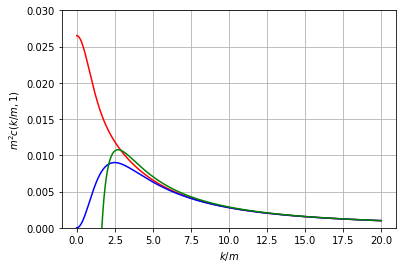

In [4]:
# correlators in momentum space
k = np.linspace(0.0001, 20, num=500)

plt.plot(k, cE(k) , 'r')
plt.plot(k, cB(k), 'b')
plt.xlabel("$k / m$")
plt.ylabel("$m^2 c(k / m, 1)$")
plt.grid()

# large k approximation
plt.plot(k, large_k_approx(k), 'g')

plt.ylim([0, 0.03])
plt.show()

# export for pgfplots 
data = np.array([k, cE(k), cB(k), np.maximum(-0.01, large_k_approx(k))]).T
np.savetxt("correlators_k.dat", data)

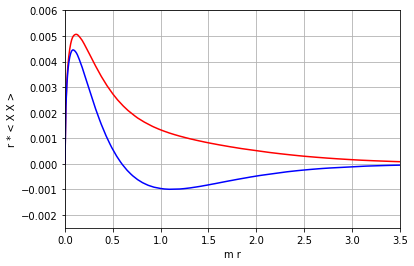

In [5]:
# correlators in coordinate space

R = np.linspace(0.00001, 5.0, num=501)
UV = 2000.0
EE = [cEr(r, UV) for r in R]
BB = [cBr(r, UV) for r in R]
#LargeK = [large_k_approx_r(r, 2.5, UV) for r in R]

plt.plot(R, R * EE, 'r')
plt.plot(R, R * BB, 'b')
#plt.plot(R, R * LargeK, 'g')

plt.xlabel("m r")
plt.ylabel("r * < X X >")

plt.xlim([0, 3.5])
plt.ylim([-0.0025, 0.006])

plt.grid()

plt.show()


# export for pgfplots 
data = np.array([R, R * EE, R * BB]).T
np.savetxt("correlators_r.dat", data)

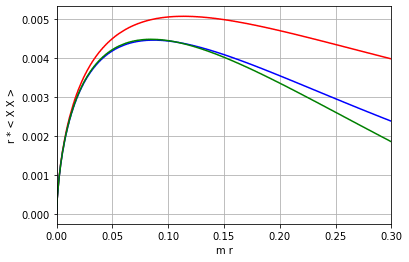

In [6]:
# zoom in on small distances
R = np.linspace(0.000001, 0.3, num=500)
UV = 4000.0
EE = [cEr(r, UV) for r in R]
BB = [cBr(r, UV) for r in R]
LargeK = [large_k_approx_r(r, 2.5, UV) for r in R]

plt.plot(R, R * EE, 'r')
plt.plot(R, R * BB, 'b')
plt.plot(R, R * LargeK, 'g')

plt.xlabel("m r")
plt.ylabel("r * < X X >")

plt.xlim([0, 0.3])
#plt.ylim([-0.0025, 0.006])

plt.grid()

plt.show()


# export for pgfplots 
data = np.array([R, R * EE, R * BB, R * LargeK]).T
np.savetxt("correlators_r_short.dat", data)

## Momentum broadening in the dilute limit

We numerically compute the function $G(\tau, \mathbf{k})$, which is used to compute accumulated transverse momenta in the dilute Glasma:

$
\left< p^2_y(\tau) \right> \propto \intop_k G(\tau, \mathbf{k}) c_B(|\mathbf{k}|)
$

$
\left< p^2_z(\tau) \right> \propto \intop_k G(\tau, \mathbf{k}) c_E(|\mathbf{k}|)
$

In [9]:
opts = {
    'limit': 200
}


def G_exp(ph, k, t):
    C_integral_re = quad(G_integrand_re, 0.0, t, args=(ph, k))[0]
    C_integral_im = quad(G_integrand_im, 0.0, t, args=(ph, k))[0]
    return C_integral_re ** 2 + C_integral_im ** 2

def G_exp_phi(k, t):
    return nquad(G_exp, [[0.0, 2*np.pi]], args=[k, t])[0] / (2 * np.pi)

@jit(float64(float64, float64, float64), nopython=True)
def G_integrand_re(tp, ph, k):
    c = np.cos(ph)
    x = k * tp
    return vec_j0(x) * np.cos(x * c) - vec_j1(x) * c * np.sin(x * c)

@jit(float64(float64, float64, float64), nopython=True)
def G_integrand_im(tp, ph, k):    
    c = np.cos(ph)
    x = k * tp
    return vec_j0(x) * np.sin(x * c) + vec_j1(x) * c * np.cos(x * c)

@jit(complex128(float64, float64, float64))
def G_integrand(tp, ph, k):    
    c = np.cos(ph)
    x = k * tp
    return (vec_j0(x) + vec_j1(x) * c * 1.0j) * np.exp(1.0j * x * c)

In [10]:
# a few checks using NIntegrate
print(G_exp_phi(1, 2.0), 1.6151)
print(G_exp_phi(3.0, 1.0), 0.129144)
print(G_exp_phi(0.5, 8.0), 3.40398)

1.6150959267799354 1.6151
0.12914388171834087 0.129144
3.403981883511848 3.40398


In [11]:
# Compute time evolution function 'G' over a range of k and t values
t_range = np.linspace(0.01, 10.0, num=40)
k_range = np.linspace(0.01, 20.0, num=200)

def G_exp_job(par):
    return G_exp_phi(par[0], par[1])

p = Pool(12)
params = np.array(list(product(k_range, t_range)))

from time import time
t1 = time()
G_table = np.array(p.map(G_exp_job, params)).reshape(len(k_range), len(t_range))
t2 = time()
print("Timing: {:3.2f} s".format(t2 - t1))

/home/dmueller/.conda/envs/gpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/dmueller/.conda/envs/gpu/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the inte

Timing: 369.48 s


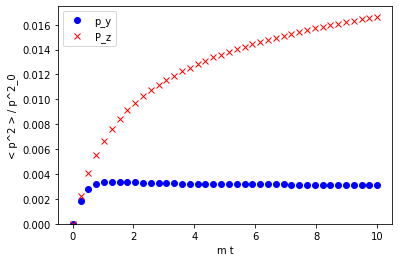

In [12]:
pys = []
pzs = []
for it, t in enumerate(t_range):
    G = G_table[:, it]
    py = simps(k_range * G * cB(k_range), k_range) / (2 * np.pi)
    pz = simps(k_range * G * cE(k_range), k_range) / (2 * np.pi)
    pys.append(py)
    pzs.append(pz)
plt.plot(t_range, pys, 'bo')
plt.plot(t_range, pzs, 'rx')
plt.ylim(0)
plt.legend(["p_y", "P_z"])
plt.xlabel("m t")
plt.ylabel("< p^2 > / p^2_0")
plt.show()


data = [t_range, pys, pzs]
data = np.array(data).T
np.savetxt("psquared_weak.dat", data)

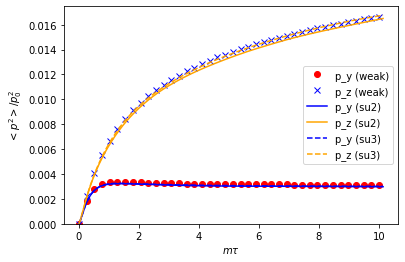

In [15]:
comparison_su2 = np.loadtxt("psquared_weak_su2.dat")
comparison_su3 = np.loadtxt("psquared_weak_su3.dat")
data = np.loadtxt("psquared_weak.dat")

t_range = data[:, 0]
pys = data[:, 1]
pzs = data[:, 2]
plt.plot(t_range, pys, 'ro')
plt.plot(t_range, pzs, 'bx')
plt.ylim(0)
plt.xlabel("$m \\tau$")
plt.ylabel("$< p^2 > / p^2_0$")

plt.plot(comparison_su2[:, 0], comparison_su2[:, 1], c='blue')
plt.plot(comparison_su2[:, 0], comparison_su2[:, 2], c='orange')

plt.plot(comparison_su3[:, 0], comparison_su3[:, 1], '--', c='blue')
plt.plot(comparison_su3[:, 0], comparison_su3[:, 2], '--', c='orange')

#plt.ylim([0, 0.004])

plt.legend(["p_y (weak)", "p_z (weak)", "p_y (su2)", "p_z (su2)", "p_y (su3)", "p_z (su3)"])

plt.show()